In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("endofnight17j03/industrial-images-dataset")

print("Path to dataset files:", path)

100%|███████████████████████████████████████████████████████████████████████████████| 248M/248M [01:42<00:00, 2.55MB/s]

Extracting files...


Path to dataset files: C:\Users\Rhea\.cache\kagglehub\datasets\endofnight17j03\industrial-images-dataset\versions\1


Sample files: ['bearingfailures-1.png', 'bearingfailures-2.png', 'bearingfailures.png', 'cable-1.jpg', 'cable.jpg']


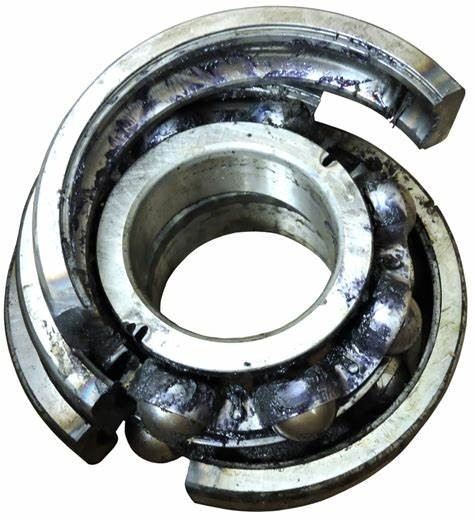

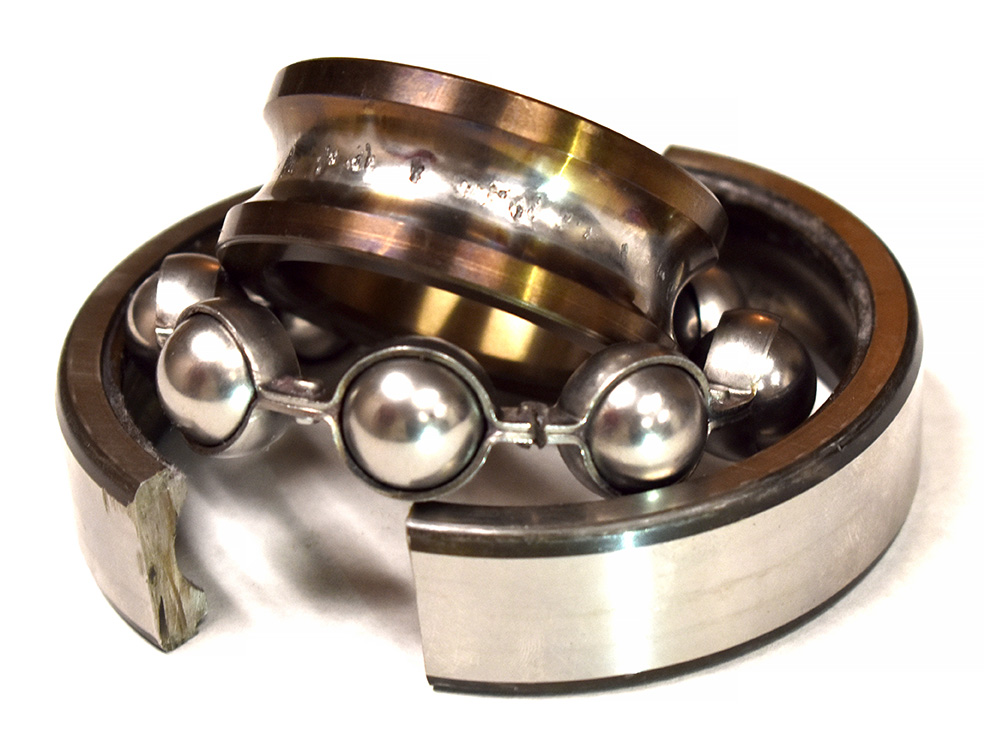

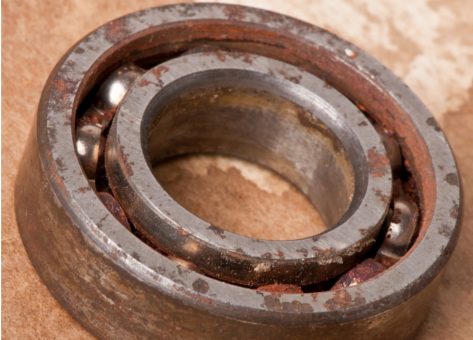

In [13]:
import os
from IPython.display import Image, display

# List a few image files
image_files = [f for f in os.listdir(r"C:\Users\Rhea\.cache\kagglehub\datasets\endofnight17j03\industrial-images-dataset\versions\1\Industrial-Equipment\Defected") if f.endswith(('jpg', 'png'))]
print("Sample files:", image_files[:5])

# Display sample images
for img_file in image_files[:3]:  # Change the number to display more/less
    display(Image(filename=os.path.join(r"C:\Users\Rhea\.cache\kagglehub\datasets\endofnight17j03\industrial-images-dataset\versions\1\Industrial-Equipment\Defected", img_file)))

Sample files: ['baring.png', 'board-1.jpg', 'compressor-1.jpg', 'grinder-1.jpg', 'grinder.jpg']


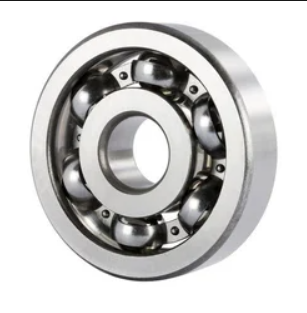

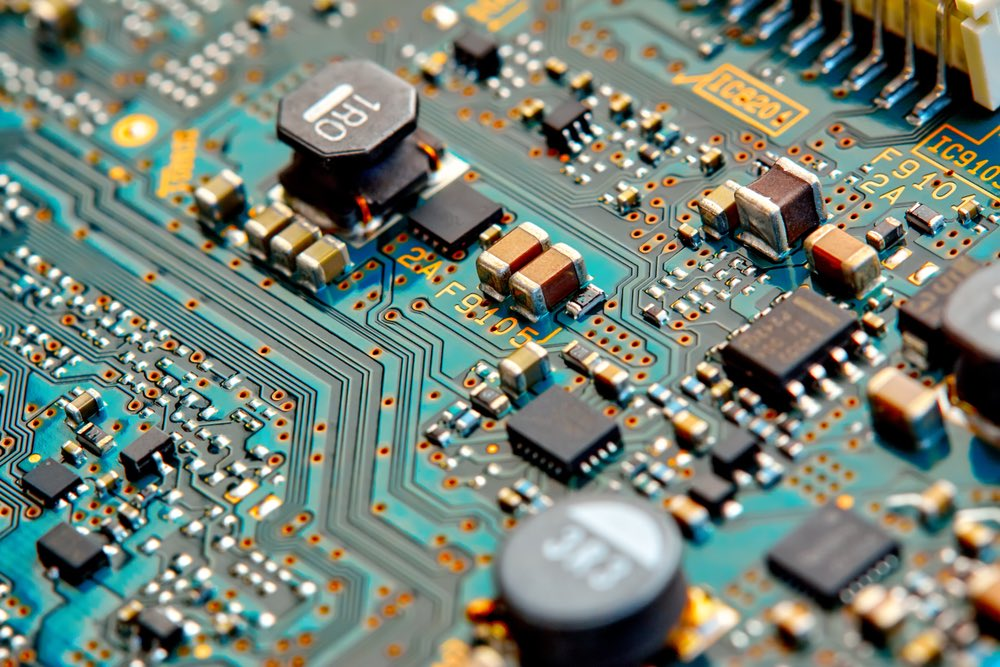

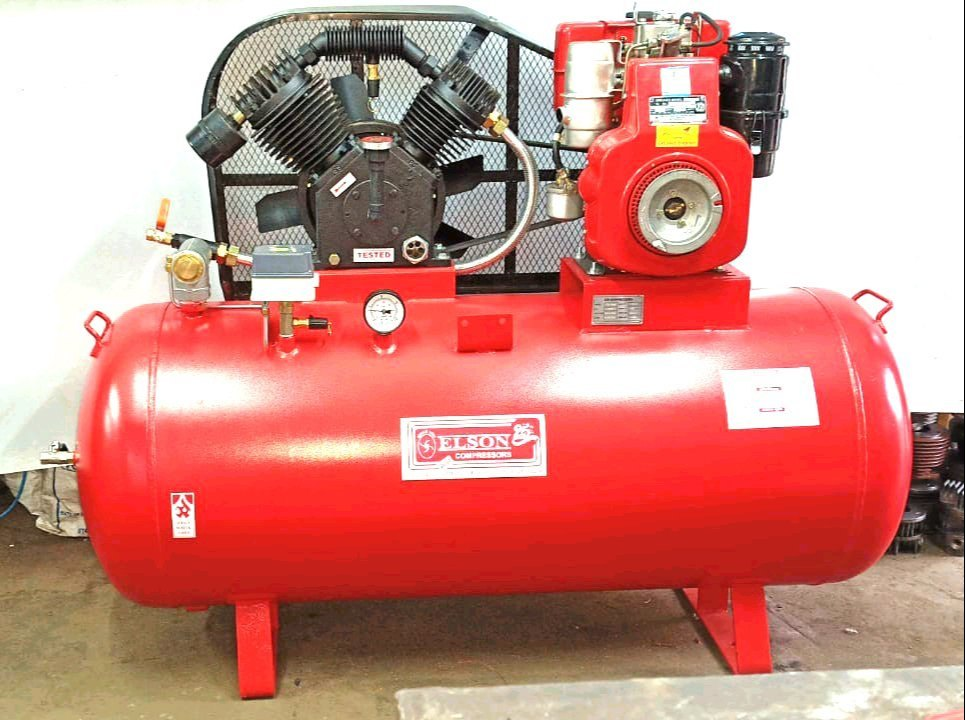

In [14]:
import os
from IPython.display import Image, display

# List a few image files
image_files = [f for f in os.listdir(r"C:\Users\Rhea\.cache\kagglehub\datasets\endofnight17j03\industrial-images-dataset\versions\1\Industrial-Equipment\Non-Defected") if f.endswith(('jpg', 'png'))]
print("Sample files:", image_files[:5])

# Display sample images
for img_file in image_files[:3]:  # Change the number to display more/less
    display(Image(filename=os.path.join(r"C:\Users\Rhea\.cache\kagglehub\datasets\endofnight17j03\industrial-images-dataset\versions\1\Industrial-Equipment\Non-Defected", img_file)))

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
# Image Parameters
base_dir = r"C:\Users\Rhea\.cache\kagglehub\datasets\endofnight17j03\industrial-images-dataset\versions\1\Industrial-Equipment"
img_size = 224
batch_size = 32

In [18]:
# Data Augmentation and Splitting
data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [19]:
# Train and Validation Generators
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='binary'
)

Found 5513 images belonging to 2 classes.


In [20]:
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='binary'
)

Found 1377 images belonging to 2 classes.


In [21]:
# Build Model using MobileNet as Base
base_model = MobileNet(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')




17225924/17225924 [==============================] - 7s 0us/step


In [22]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

X = Flatten()(base_model.output)
X = Dense(128, activation='relu')(X)
X = Dense(1, activation='sigmoid')(X)
model = Model(inputs=base_model.input, outputs=X)


In [23]:
# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [24]:
# Define Callbacks
mc = ModelCheckpoint(filepath="./bestmodel.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
es = EarlyStopping(monitor="val_accuracy", patience=3, verbose=1)
callbacks = [mc, es]

In [25]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks
)

Epoch 1/20


172/172 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.7506
Epoch 1: val_accuracy improved from -inf to 0.96221, saving model to .\bestmodel.keras
172/172 [==============================] - 142s 816ms/step - loss: 0.9424 - accuracy: 0.7506 - val_loss: 0.3575 - val_accuracy: 0.9622
Epoch 2/20
172/172 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9580
Epoch 2: val_accuracy improved from 0.96221 to 0.97238, saving model to .\bestmodel.keras
172/172 [==============================] - 103s 601ms/step - loss: 0.2219 - accuracy: 0.9580 - val_loss: 0.0701 - val_accuracy: 0.9724
Epoch 3/20
172/172 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9807
Epoch 3: val_accuracy improved from 0.97238 to 0.98983, saving model to .\bestmodel.keras
172/172 [==============================] - 105s 608ms/step - loss: 0.0582 - accuracy: 0.9807 - val_loss: 0.0341 - val_accuracy: 0.9898
Epoch 4/20
172/172 [==================

In [26]:
# Evaluate the Model
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


43/43 [==============================] - 20s 463ms/step - loss: 0.0594 - accuracy: 0.9666
Validation Accuracy: 96.66%


Text(0.5, 1.0, 'Accuracy')

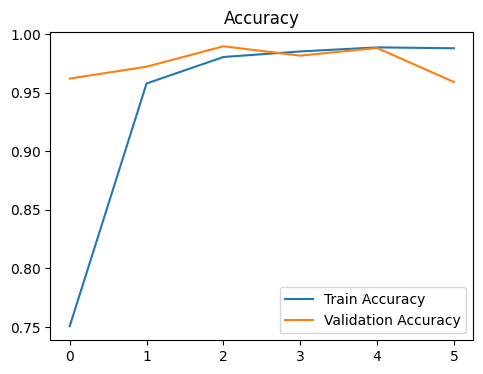

In [27]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

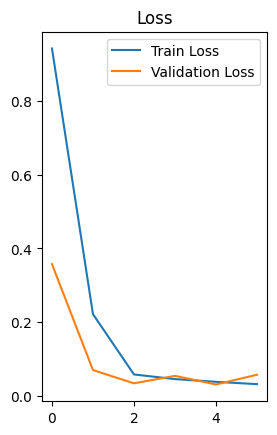

In [28]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [29]:
# Predict Sample Image
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet import preprocess_input

In [30]:
path = r"D:\SYMBIOSIS\defected-or-nondefected\charger.jpg"  # Update with actual sample image path
img = load_img(path, target_size=(224, 224))
input_arr = img_to_array(img)
input_arr = preprocess_input(input_arr)
input_arr = np.expand_dims(input_arr, axis=0)

In [31]:
predictions = model.predict(input_arr)
predicted_class = "Non-Defective" if predictions[0][0] < 0.5 else "Defective"
print("Predicted class:", predicted_class)

1/1 [==============================] - 1s 504ms/step
Predicted class: Defective
